In [1]:
import tensorflow as tf
import csv
import os
import pandas as pd
import numpy as np
import shutil
import PIL
from pathlib import Path
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import glob
import piexif
from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image
from PIL import ImageFile
Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau 
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from itertools import tee 
from sklearn import metrics
from tensorflow.keras import backend as K
from sklearn.metrics import f1_score,precision_score,recall_score
import seaborn as sns

In [2]:
labelsCsv = pd.read_csv("C:/Users/manta/Desktop/new.csv")

# When generating datasets from dataframe,using ImageDataGenerator, we noticed that train and valid sets
# had a class less than the test set. So comparing the labels we realised that one single tittle had the genre
# 'Game-Show' which we have to remove so each set has the same classes
#labelsCsv = labelsCsv[~labelsCsv.genres.str.contains("Game-Show")]
#labelsCsv = labelsCsv[~labelsCsv.genres.str.contains("Short")]
#labelsCsv.to_csv("labels.csv", sep=",", index=False)

nfiles = 0

# We remove exif metadata from pictures and resize them to max size of 128x128, while maintaining the aspect ratio
# of the original photo

#for filename in glob.iglob('E:/IMDB_/*.jpg', recursive=True):
    #nfiles = nfiles + 1
    #print("About to process file %d, which is %s." % (nfiles,filename))
    #piexif.remove(filename)

size=(128, 128)

#for filename in glob.iglob('E:/IMDB_rs/*.jpg', recursive=True):
    #im = Image.open(filename)
    #im.thumbnail(size, Image.ANTIALIAS)
    #x = filename.split("\\", 1)
    #im.save("C:/IMDB_mr/"+x[1], "JPEG")



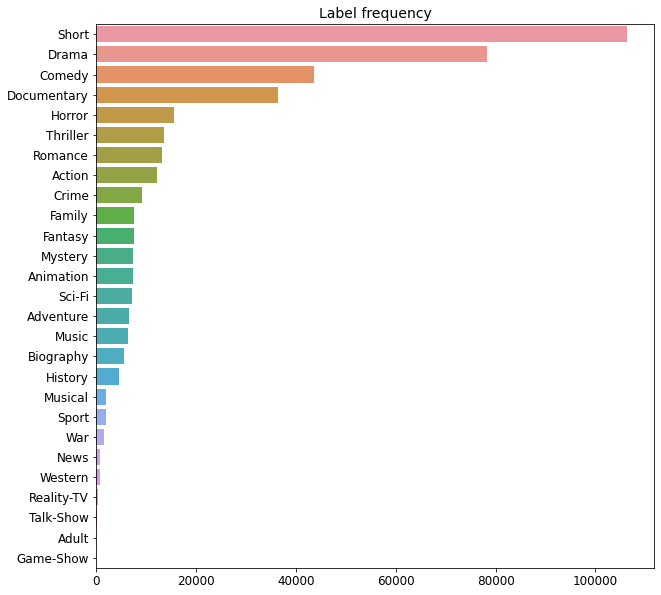

In [3]:
# Get label frequencies in descending order
label_freq = labelsCsv['genres'].apply(lambda s: str(s).split(',')).explode().value_counts().sort_values(ascending=False)

# Bar plot
plt.figure(figsize=(10,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [4]:
print(label_freq)

Short          106387
Drama           78246
Comedy          43675
Documentary     36538
Horror          15659
Thriller        13613
Romance         13234
Action          12244
Crime            9257
Family           7663
Fantasy          7646
Mystery          7431
Animation        7401
Sci-Fi           7310
Adventure        6581
Music            6331
Biography        5673
History          4589
Musical          2010
Sport            1989
War              1530
News              767
Western           723
Reality-TV        430
Talk-Show         212
Adult              53
Game-Show          22
Name: genres, dtype: int64


In [5]:
#we keep only the movie relevant genres
excluded = ['Talk-Show','Sport','News','Reality-TV','Game-Show','Adult', 'Short']

for x in excluded:
    labelsCsv = labelsCsv[~labelsCsv.genres.str.contains(x)] 

    


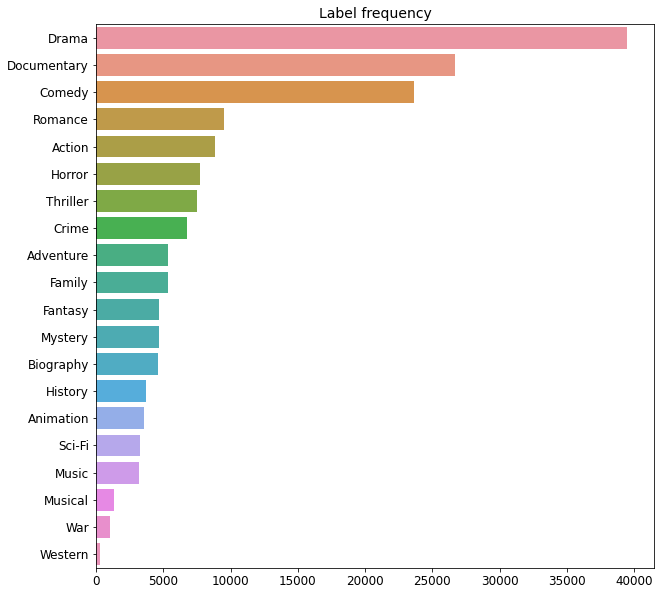

In [6]:
label_freqNew = labelsCsv['genres'].apply(lambda s: str(s).split(',')).explode().value_counts().sort_values(ascending=False)

# Bar plot after we dropped the classes
plt.figure(figsize=(10,10))
sns.barplot(y=label_freqNew.index.values, x=label_freqNew, order=label_freqNew.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [7]:
print(label_freqNew)

Drama          39496
Documentary    26705
Comedy         23619
Romance         9481
Action          8863
Horror          7702
Thriller        7534
Crime           6794
Adventure       5343
Family          5319
Fantasy         4706
Mystery         4704
Biography       4603
History         3685
Animation       3606
Sci-Fi          3284
Music           3219
Musical         1347
War             1028
Western          300
Name: genres, dtype: int64


In [8]:
#  under1000 = list(label_freq[label_freq<1000].index)
#  under1000

In [9]:
# for x in under1000:
#    labelsCsv = labelsCsv[~labelsCsv.genres.str.contains(x)] 

In [10]:
# # Get label frequencies in descending order
# label_freq = labelsCsv['genres'].apply(lambda s: str(s).split(',')).explode().value_counts().sort_values(ascending=False)

# # Bar plot
# plt.figure(figsize=(10,10))
# sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
# plt.title("Label frequency", fontsize=14)
# plt.xlabel("")
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.show()

In [11]:
all_genres = [[genre for genre in cel.split(',')] for cel in labelsCsv.genres]
one_hot = MultiLabelBinarizer()
y_s =one_hot.fit_transform(np.array(all_genres))
y_s


c:\programdata\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [12]:
len(y_s[0])

20

In [13]:
# testss = pd.DataFrame(one_hot.fit_transform(all_genres),columns=one_hot.classes_, index=labelsCsv.index)
# testss



In [14]:
# creating and formating the dataset that we are going to use
d = {'filename' : [tconst + ".jpg" for tconst in labelsCsv.tconst],
    'labels' : [[genre for genre in cel.split(',')] for cel in labelsCsv.genres]}

img_metadata_df = pd.DataFrame(d)

train, test = train_test_split(img_metadata_df, test_size=0.20, random_state=9, shuffle=True)
data_dir="C:/IMDB_rs/"
train_path = Path(data_dir, 'train.csv')
test_path = Path(data_dir, 'test.csv')
train.to_csv(train_path, sep=',', index=False)
test.to_csv(test_path, sep=',', index=False)

In [15]:
# defining the geerators that are going to pass batches of images during training
# rescaled and resized while performing a validation split in 0.2
img_gen = ImageDataGenerator(rescale=1./255., validation_split=0.2)

img_iter_train = img_gen.flow_from_dataframe(
    dataframe=train,
    shuffle=True,
    seed = 42,
    directory="C:/IMDB_rs/",
    x_col='filename',
    y_col='labels',
    class_mode='categorical',
    target_size=(128, 128),
    batch_size=100,
    subset='training'
) 

img_iter_val = img_gen.flow_from_dataframe(
    dataframe=train,
    shuffle=True,
    seed = 42,
    directory="C:/IMDB_rs/",
    x_col='filename',
    y_col='labels',
    class_mode='categorical',
    target_size=(128, 128),
    batch_size=200,
    subset='validation'
) 

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory="C:/IMDB_rs/",
x_col='filename',
y_col='labels',
class_mode='categorical',
batch_size=1,
seed=42,
shuffle=False,
target_size=(128, 128)
)


c:\programdata\anaconda3\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 63301 validated image filenames belonging to 20 classes.


c:\programdata\anaconda3\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 15825 validated image filenames belonging to 20 classes.
Found 19782 validated image filenames belonging to 20 classes.


In [16]:
# img_iter_train.classes
# #counter = Counter(tuple(item) for item in img_iter_train.classes)
# flat_list = [item for sublist in img_iter_train.classes for item in sublist]
# counter = Counter(flat_list)
# counter = dict(sorted(counter.items()))
# counter

In [17]:
THRESHOLD = 0.5
def precision(y_true, y_pred, threshold_shift=0.5-THRESHOLD):

    # just in case 
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))

    precision = tp / (tp + fp)
    return precision


def recall(y_true, y_pred, threshold_shift=0.5-THRESHOLD):

    # just in case 
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fn = K.sum(K.round(K.clip(y_true - y_pred_bin, 0, 1)))

    recall = tp / (tp + fn)
    return recall

def fbeta(y_true, y_pred, threshold_shift=0.5-THRESHOLD):
    #balanced on precision and recall
    beta = 1

    # just in case 
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall) 


In [18]:
# # definging the model and compiling using Adam optimizer with a learning
# # rate of 0.001 and metry validation accuracy
# model = Sequential([
# Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(128,128,3)),
# MaxPooling2D(pool_size=(2, 2)),
# Dropout(0.25),
# Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
# MaxPooling2D(pool_size=(2, 2)),
# Dropout(0.25),
# Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
# MaxPooling2D(pool_size=(2, 2)),
# Dropout(0.25),
# Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
# MaxPooling2D(pool_size=(2, 2)),
# Dropout(0.25),

# Flatten(),
    
# Dense(128, activation='relu'),
# Dropout(0.5),
# Dense(64, activation='relu'),
# Dropout(0.5),
# Dense(25, activation='sigmoid')
# ])

# model.compile(optimizer=Adam(lr = 0.001), 
#               loss='binary_crossentropy', 
#               metrics=[precision,recall])

In [19]:
base_MobNet = tf.keras.applications.MobileNetV2( include_top=False, weights="imagenet", input_shape = (128,128,3))
base_MobNet.layers.pop()
mob_model = Model(base_MobNet.input, base_MobNet.layers[-6].output)
mob_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________________

In [20]:
for layer in mob_model.layers:
    layer.trainable = False        

In [21]:
#Adding the final layers to the above base models where the actual classification is done in the dense layers
model_mobnet = Sequential()
model_mobnet.add(mob_model) 
model_mobnet.add(Flatten()) 
model_mobnet.add(Dense(1024,activation=('relu'),input_dim=512))
model_mobnet.add(Dropout(.4))
model_mobnet.add(Dense(512,activation=('relu'))) 
model_mobnet.add(Dropout(.4))
model_mobnet.add(Dense(256,activation=('relu'))) 
model_mobnet.add(Dropout(.4))
model_mobnet.add(Dense(128,activation=('relu')))
model_mobnet.add(Dropout(.4))
model_mobnet.add(Dense(20,activation=('sigmoid')))

In [22]:
layercnt = 0
for layer in model_mobnet.layers:
    layercnt =layercnt +1
    
layercnt    

11

In [23]:
model_mobnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 4, 4, 960)         1534784   
_________________________________________________________________
flatten (Flatten)            (None, 15360)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              15729664  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1

In [24]:
model_mobnet.compile(optimizer=Adam(lr = 0.0001), 
              loss='binary_crossentropy', 
              metrics=[precision,recall,fbeta])

In [25]:
# es = EarlyStopping(monitor = 'val_loss',
#                            mode = 'min',
#                            verbose = 2,
#                            patience = 20,
#                            min_delta = 0.001,
#                            restore_best_weights = True)

# reduce_lr = ReduceLROnPlateau(monitor='val_precision', factor=0.5, patience=2, 
#                                    verbose=1, mode='max', min_lr=0.00001)

In [26]:
STEP_SIZE_TRAIN=img_iter_train.n//img_iter_train.batch_size
STEP_SIZE_VALID=img_iter_val.n//img_iter_val.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size


In [27]:
# history = model.fit_generator(
#     generator = img_iter_train,
#     validation_data = img_iter_val,
#     epochs=1000,
#     steps_per_epoch = STEP_SIZE_TRAIN,
#     validation_steps= STEP_SIZE_VALID,
# )

In [28]:
history = model_mobnet.fit_generator(
    generator = img_iter_train,
    validation_data = img_iter_val,
    epochs=1000,
    steps_per_epoch = STEP_SIZE_TRAIN,
    validation_steps= STEP_SIZE_VALID,
)

Epoch 1/1000
633/633 [==============================] - 120s 189ms/step - loss: 0.3333 - precision: 0.2590 - recall: 0.1223 - fbeta: 0.1298 - val_loss: 0.2591 - val_precision: 0.5753 - val_recall: 0.0022 - val_fbeta: 0.0027
Epoch 2/1000
633/633 [==============================] - 119s 189ms/step - loss: 0.2722 - precision: 0.4009 - recall: 0.0890 - fbeta: 0.1052 - val_loss: 0.2757 - val_precision: 0.5472 - val_recall: 0.0269 - val_fbeta: 0.0332
Epoch 3/1000
633/633 [==============================] - 119s 188ms/step - loss: 0.2602 - precision: 0.4509 - recall: 0.0831 - fbeta: 0.0991 - val_loss: 0.2719 - val_precision: 0.6128 - val_recall: 0.0611 - val_fbeta: 0.0745
Epoch 4/1000
633/633 [==============================] - 120s 189ms/step - loss: 0.2547 - precision: 0.4810 - recall: 0.0851 - fbeta: 0.1018 - val_loss: 0.2672 - val_precision: 0.5692 - val_recall: 0.0836 - val_fbeta: 0.1008
Epoch 5/1000
633/633 [==============================] - 121s 191ms/step - loss: 0.2502 - precision: 0.50

KeyboardInterrupt: 

In [ ]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['training', 'validation'], loc='upper left')
# plt.show()

In [ ]:
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

In [ ]:
test_generator.reset()
model.evaluate_generator(generator = test_generator, 
                         steps=STEP_SIZE_TEST,
                         verbose=1)

In [ ]:
model.save('C:/IMDB_mr/Model/')
np.savetxt("preds.csv", pred, delimiter=",")

# TEXT ANALYSIS

In [ ]:
len(labelsCsv.desc)

In [ ]:
len(y_s)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from tensorflow.keras.layers import Embedding
from nltk.stem.snowball import SnowballStemmer 
import re

# Others
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.manifold import TSNE

In [ ]:
textdata = labelsCsv[['desc','genres']]
textdata= textdata.dropna()
textdata = textdata[textdata['desc'].notnull()]
txtrain, txtest = train_test_split(textdata, test_size=0.20, random_state=9, shuffle=True)

In [ ]:
### Text Normalizing function. Part of the following function was taken from this link. 
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"directed", "", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"\=", " = ", text)
    

    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    
    return text


In [ ]:
txtrain['desc'] = txtrain['desc'].map(lambda x: clean_text(x))

In [ ]:
### Create sequence
#vocabulary_size = 20000
tokenizer = Tokenizer()
tokenizer.fit_on_texts(txtrain['desc'] )   #sto test
sequences = tokenizer.texts_to_sequences(txtrain['desc'] )  #sto test
vocabulary_size = len(tokenizer.word_index) + 1
maxlen = max([len(x) for x in sequences])
xtrain = pad_sequences(sequences, maxlen)  #kai sto test

print(xtrain.shape)

In [ ]:
xtrain

In [ ]:
all_genres_tx = [[genre for genre in cel.split(',')] for cel in txtrain.genres] #sto test
ytrain = one_hot.fit_transform(np.array(all_genres_tx))   #sto test
ytrain.shape

Extract word embeddings from the Glove


In [ ]:
embeddings_index = dict()
f = open('C:/Users/manta/Desktop/glove.6B/glove.6B.200d.txt',  encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()



Create a weight matrix

In [ ]:
embedding_matrix = np.zeros((vocabulary_size, 200))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

Create datasets

Develop a model


In [ ]:
## create model
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 200, input_length=76, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(25, activation='sigmoid')
)

model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=[recall,precision])


In [ ]:
## Fit train data
model_glove.fit(xtrain, ytrain, validation_split=0.3, epochs = 100)

In [ ]:
len(ytrain[0])

In [ ]:
vocabulary_size